# Установка необходимых библиотек

In [122]:
! pip install pandas scikit-learn tensorflow matplotlib tqdm aiohttp nest_asyncio seaborn scipy

# Подключение необходимых библиотек для работы

In [280]:
import asyncio
from typing import Any

import aiohttp
import nest_asyncio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score,confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
from scipy import stats

# Константы

In [6]:
# Ключ к API
API_KEY = 'XBSZVHENMkRnmafKAoJpPzXJCsrnVRX3Pdp7RXd5'
# Базовый URL
BASE_URL = 'https://api.nal.usda.gov/fdc/v1/foods'
# Ключевые столбцы для анализа
KEY_COLUMNS = {
    'Energy': 'Энергия',
    'Protein': 'Белок',
    'Total lipid (fat)': 'Общие липиды (жиры)',
    'Carbohydrate, by difference': 'Углеводы',
    'Fiber, total dietary': 'Пищевые волокна',
    'Sugars, total including NLEA': 'Общие сахара',
    'Sodium, Na': 'Натрий, Na',
}
# Количество элементов на странице
PAGE_SIZE = 200

# Загрузка данных

In [4]:
# Функция загрузки данных
async def fetch_data(page_size: int, page_number: int) -> list[dict[str, Any]]:
    params = {
        'api_key': API_KEY,
        'pageSize': page_size,
        'pageNumber': page_number
    }
    async with aiohttp.ClientSession() as session:
        async with session.get(BASE_URL + '/list', params=params) as response:
            return await response.json()


# Функция получения количества страниц
async def get_total_page(page_size: int) -> int:
    params = {
        'api_key': API_KEY,
        'pageSize': page_size
    }
    async with aiohttp.ClientSession() as session:
        async with session.get(
                BASE_URL + '/search',
                params=params
        ) as response:
            result = await response.json()
            return result['totalPages']

In [5]:
# Парсер загруженных данных
def parse_data(data: list[dict[str, Any]]) -> pd.DataFrame:
    rows = []

    for item in data:
        try:
            nutrients = item.get('foodNutrients', [])
        except AttributeError:
            continue
        row = {}
        for nutrient in nutrients:
            if nutrient.get('amount') is not None:
                if nutrient['name'] in KEY_COLUMNS:
                    row[nutrient['name']] = nutrient['amount']
        rows.append(row)
    return pd.DataFrame(rows)


In [41]:
# Функция получения датасета
async def get_dataset() -> pd.DataFrame:
    df = pd.DataFrame()
    total_pages = await get_total_page(page_size=PAGE_SIZE)
    for page in tqdm(range(1, total_pages + 1), desc='Загрузка данных', unit='Страница'):
        data = await fetch_data(page_size=PAGE_SIZE, page_number=page)
        data = parse_data(data)
        df = pd.concat([df, data], ignore_index=True)
    df = df.rename(columns=KEY_COLUMNS)
    return df

In [42]:
# Получение датасета
df = await get_dataset()

Загрузка данных: 100%|██████████| 2337/2337 [15:44<00:00,  2.47Страница/s]


In [43]:
# Сохранение датасета в файле
df.to_csv('food_dataset.csv', index=False)

# Анализ датасета

In [209]:
# Загрзка датасета
df = pd.read_csv('food_dataset.csv')


In [210]:
# Размер датасета
df.shape

(50000, 7)

In [211]:
# Вывод первых пяти элементов
df.head()

,Белок,Общие липиды (жиры),Углеводы,Энергия,Общие сахара,Пищевые волокна,"Натрий, Na"
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21.2,6.12,7.46,177.0,0.0,0.0,574.0
2,1.5,0.10,17.60,69.0,NaN,5.3,20.0
3,0.4,0.30,4.80,23.0,NaN,0.3,3.0
4,0.4,0.30,7.69,32.0,NaN,1.1,7.0


In [212]:
# Просмотр формата и количества значений
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Белок                49598 non-null  float64
 1   Общие липиды (жиры)  49521 non-null  float64
 2   Углеводы             49225 non-null  float64
 3   Энергия              49194 non-null  float64
 4   Общие сахара         5624 non-null   float64
 5   Пищевые волокна      42965 non-null  float64
 6   Натрий, Na           49205 non-null  float64
dtypes: float64(7)
memory usage: 2.7 MB


In [213]:
# Описание числовых столбцов
df.describe()

,Белок,Общие липиды (жиры),Углеводы,Энергия,Общие сахара,Пищевые волокна,"Натрий, Na"
count,49598.000000,49521.000000,49225.000000,49194.000000,5624.000000,42965.000000,4.920500e+04
mean,8.391191,11.734235,27.317507,290.447973,6.801118,2.452548,1.007581e+03
std,10.457854,18.169831,44.210295,362.448344,12.082020,5.271475,2.599314e+04
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,0.830000,0.140000,4.050000,88.000000,0.700000,0.000000,2.700000e+01
50%,5.560000,4.990000,15.200000,235.000000,2.330000,1.000000,2.030000e+02
75%,12.500000,16.800000,49.500000,391.000000,6.990000,3.200000,5.000000e+02
max,760.000000,1170.000000,6160.000000,37600.000000,99.800000,588.000000,4.690000e+06


In [214]:
# Проверка наличия пропусков
df.isnull().sum()

,0
Белок,402
Общие липиды (жиры),479
Углеводы,775
Энергия,806
Общие сахара,44376
Пищевые волокна,7035
"Натрий, Na",795


# Корректировка данных

In [215]:
# Заполнение пропусков нулями
df.fillna(0, inplace=True)

In [216]:
# Очистка данных с большим количеством нулевых значений
threshold = 3
df['Количество нулей'] = (df[KEY_COLUMNS.values()] == 0).sum(axis=1)
df_filtered = df[df['Количество нулей'] < threshold]
df = df_filtered.drop(columns=['Количество нулей'])

In [217]:
# Просмотр текущего размера
df.shape

(32567, 7)

# Анализ данных

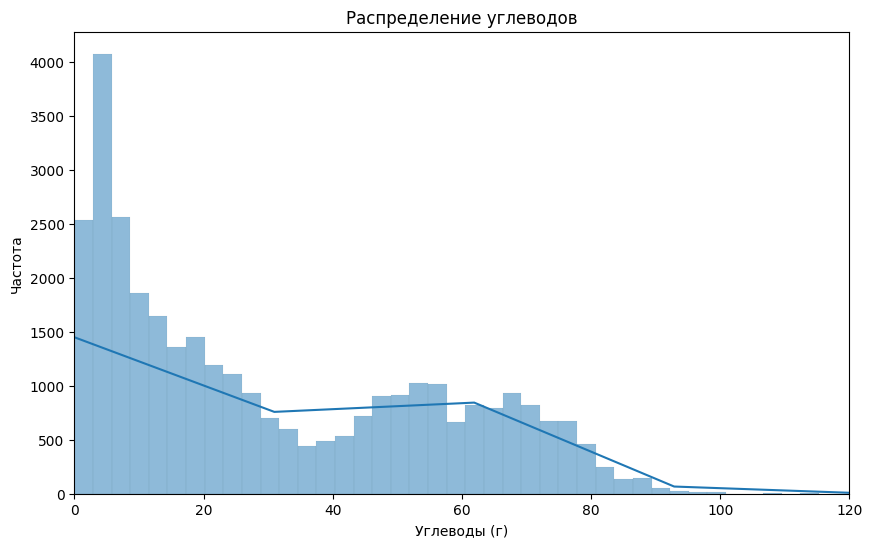

In [218]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Углеводы'], kde=True)
plt.title('Распределение углеводов')
plt.xlabel('Углеводы (г)')
plt.ylabel('Частота')
plt.xlim(0, 120)
plt.show()

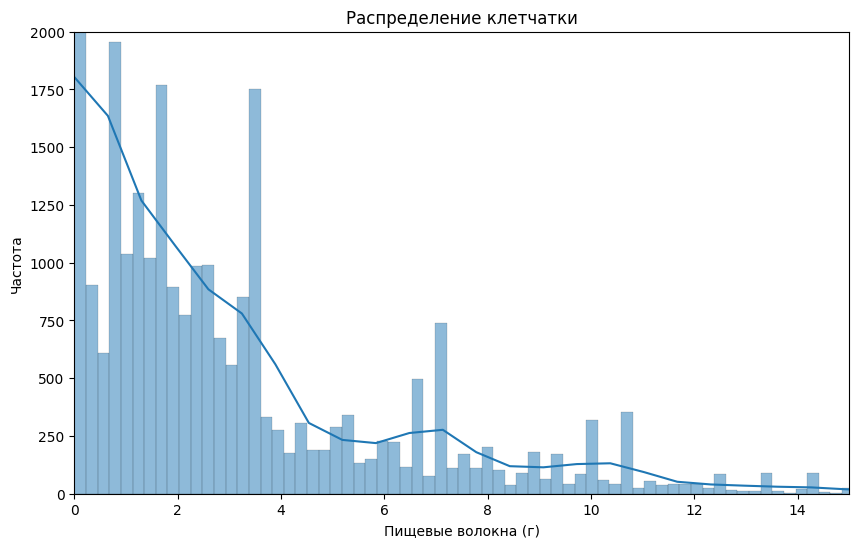

In [107]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Пищевые волокна'], kde=True)
plt.title('Распределение клетчатки')
plt.xlabel('Пищевые волокна (г)')
plt.ylabel('Частота')
plt.xlim(0, 15)
plt.ylim(0, 2000)
plt.show()

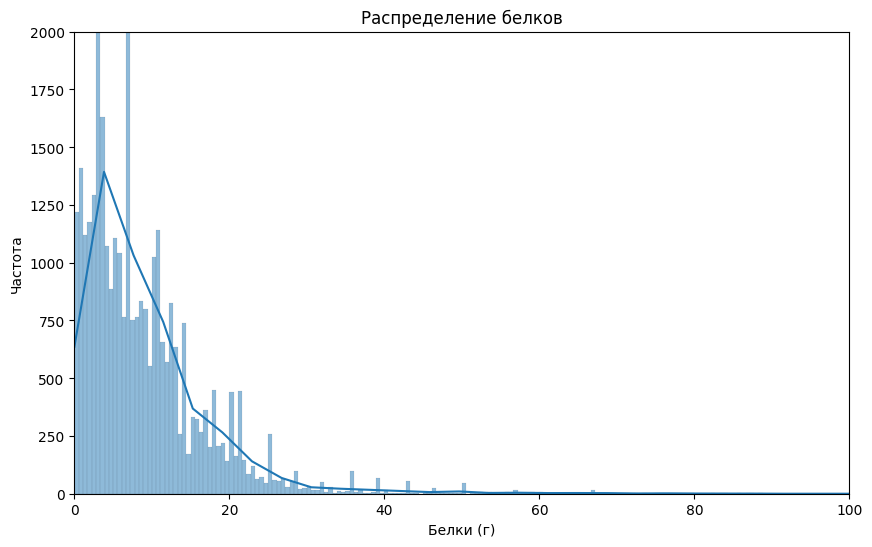

In [108]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Белок'], kde=True)
plt.title('Распределение белков')
plt.xlabel('Белки (г)')
plt.ylabel('Частота')
plt.xlim(0, 100)
plt.ylim(0, 2000)
plt.show()

# Выявление выбросов

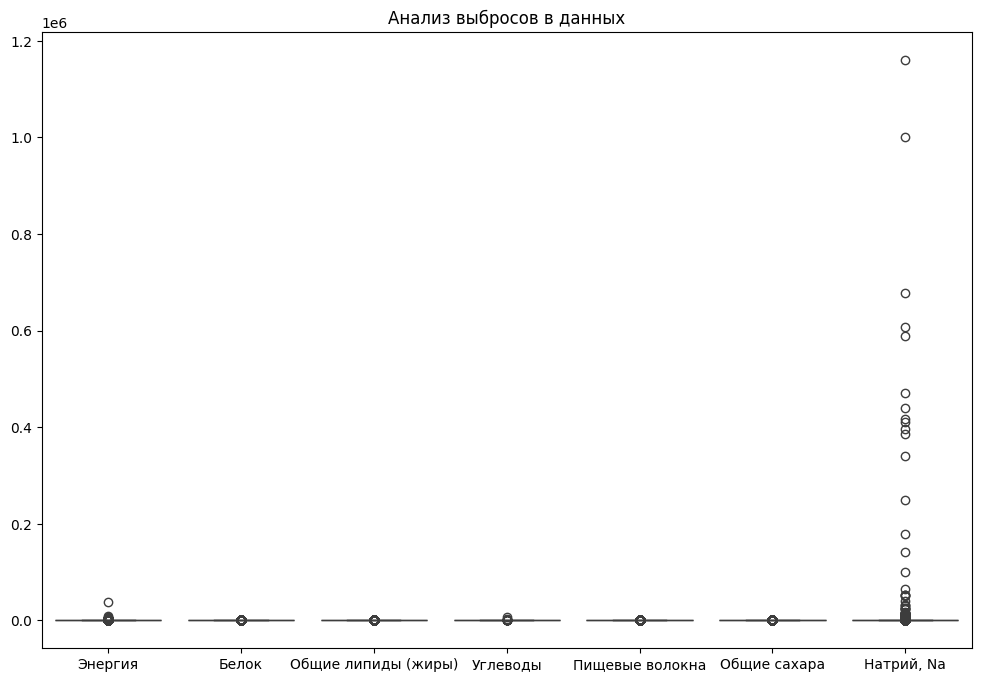

In [219]:
# Выявление выбросов
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[KEY_COLUMNS.values()])
plt.title('Анализ выбросов в данных')
plt.show()

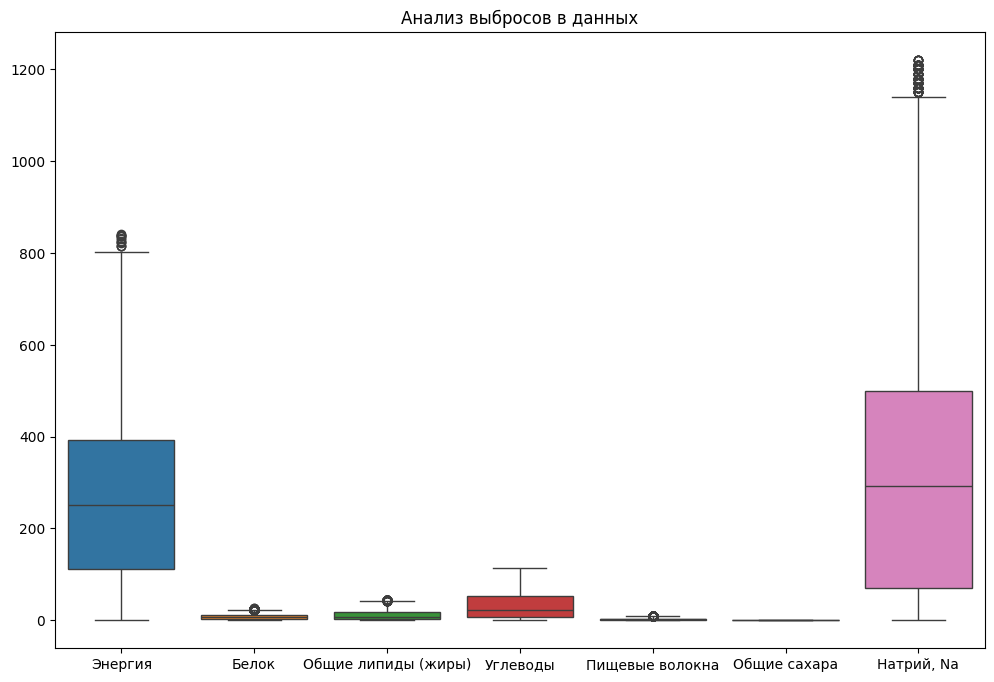

In [220]:
# Фильтрация выбросов на основе модели IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]

# Анализ выбросов данных
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[KEY_COLUMNS.values()])
plt.title('Анализ выбросов в данных')
plt.show()

# Добавление коэффициента оценки продукта

In [221]:
# Функция нормализции
def normalize(
        min_value: int,
        value: int | np.float64,
        max_value: int
) -> float:
    if np.isnan(value):
        return 0
    return 10 * (value - max_value) / (max_value - min_value)

In [261]:
# Функция получения оценки
def calc_health_score(
        row: pd.DataFrame
) -> float:
    data = {
        'protein': [0, row['Белок'], 100],
        'fat': [0, row['Общие липиды (жиры)'], 70],
        'carbs': [0, row['Углеводы'], 120],
        'fiber': [0, row['Пищевые волокна'], 15],
        'sugar': [0, row['Общие сахара'], 50],
        'sodium': [0, row['Натрий, Na'], 2000]
    }

    # Веса
    weight_protein = 0.2
    weight_fat = 0.2
    weight_carbs = 0.1
    weight_fiber = 0.2
    weight_sugar = 0.2
    weight_sodium = 0.1

    # Расчетная формула
    health_score = (weight_protein * normalize(*data['protein']) +
                    weight_fat * normalize(*data['fat']) +
                    weight_carbs * normalize(*data['carbs']) +
                    weight_fiber * normalize(*data['fiber']) +
                    weight_sugar * normalize(*data['sugar']) +
                    weight_sodium * normalize(*data['sodium']))
    if health_score >= -8.6:
        return 0
    return 1

In [262]:
# Добавление критерия оценки
df['Оценка здоровья'] = df.apply(lambda row: calc_health_score(row), axis=1)

In [263]:
# Вывод первых десяти элементов
df.head(10)

,Белок,Общие липиды (жиры),Углеводы,Энергия,Общие сахара,Пищевые волокна,"Натрий, Na",Оценка здоровья
1,21.20,6.12,7.46,177.0,0.0,0.0,574.0,1
2,1.50,0.10,17.60,69.0,0.0,5.3,20.0,1
3,0.40,0.30,4.80,23.0,0.0,0.3,3.0,1
4,0.40,0.30,7.69,32.0,0.0,1.1,7.0,1
5,6.81,3.47,9.22,95.0,0.0,0.7,130.0,1
12,0.52,0.15,16.20,68.0,0.0,6.6,14.0,1
14,3.40,31.80,13.40,353.0,0.0,0.5,21.0,1
15,21.70,18.60,0.90,258.0,0.0,0.0,95.0,1
25,0.06,0.06,6.94,186.0,0.0,0.1,5.0,1
36,0.10,0.30,32.20,308.0,0.0,0.0,8.0,1


In [264]:
# Вывод количества оценок
result = {
    0: 0,
    1: 0
}

for i in df['Оценка здоровья']:
  result[i] += 1
print(result)

{0: 8115, 1: 14132}


# Разделение данных на обучающую и тестовую выборку

In [265]:
# Признаки
x = df.drop(columns=['Оценка здоровья'])
x.head()

,Белок,Общие липиды (жиры),Углеводы,Энергия,Общие сахара,Пищевые волокна,"Натрий, Na"
1,21.20,6.12,7.46,177.0,0.0,0.0,574.0
2,1.50,0.10,17.60,69.0,0.0,5.3,20.0
3,0.40,0.30,4.80,23.0,0.0,0.3,3.0
4,0.40,0.30,7.69,32.0,0.0,1.1,7.0
5,6.81,3.47,9.22,95.0,0.0,0.7,130.0


In [269]:
# Целевые переменные
y = df['Оценка здоровья']

In [274]:
# Зададим размер обучающей выборки
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.4, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# Создадим модель обучения

In [291]:
# Модель MLP
model = Sequential()
model.add(Input(shape=(x_train.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [292]:
# Компиляция модели
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [293]:
# Обучение модели
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4842 - loss: 35.5259 - val_accuracy: 0.5959 - val_loss: 6.8297
Epoch 2/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5075 - loss: 22.1693 - val_accuracy: 0.5950 - val_loss: 4.6221
Epoch 3/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5209 - loss: 14.5488 - val_accuracy: 0.5779 - val_loss: 2.2323
Epoch 4/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5235 - loss: 10.1008 - val_accuracy: 0.5442 - val_loss: 1.3285
Epoch 5/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5316 - loss: 6.7970 - val_accuracy: 0.5064 - val_loss: 1.2150
Epoch 6/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5242 - loss: 5.1329 - val_accuracy: 0.5131 - val_loss: 0.9062
Epoch 7/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5510 - loss: 3.3962 - val_accuracy: 0.5999 - val_loss: 0.6744
Epoch 8/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5542 - loss: 2.5242 - val_accuracy

# Оценка модели

In [294]:
# Получение предсказания
y_pred = model.predict(x_test)
y_pred_class = (y_pred > 0.5).astype(int)
# Вычисление точности модели
accuracy = accuracy_score(y_test, y_pred_class)

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [295]:
# Точность модели
print(accuracy)

0.838876404494382


# Визуализация процесса обучения

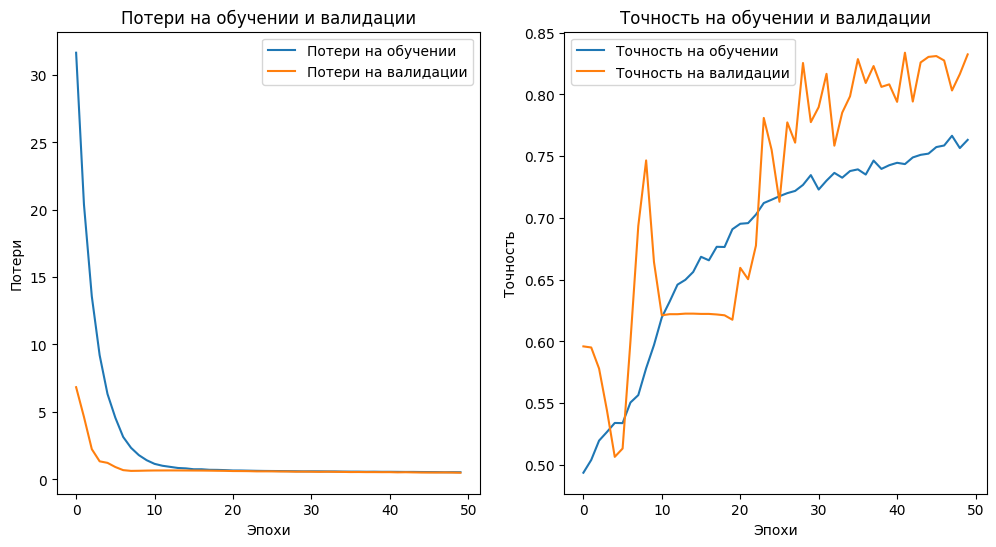

In [296]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Потери на обучении')
plt.plot(history.history['val_loss'], label='Потери на валидации')
plt.title('Потери на обучении и валидации')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Точность на обучении')
plt.plot(history.history['val_accuracy'], label='Точность на валидации')
plt.title('Точность на обучении и валидации')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()

plt.show()

# Матрица ошибок

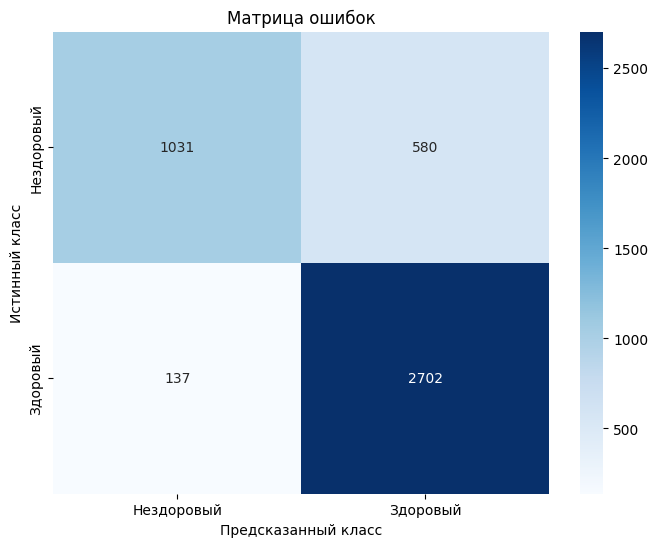

In [297]:
cm = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Нездоровый', 'Здоровый'], yticklabels=['Нездоровый', 'Здоровый'])
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.show()

# Сохранение модели

In [298]:
model.save("model.keras")